# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
experiment_name = 'explore_demand_test'

# load Java simulation data
# experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
experiment_folder = fr'data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]
    
                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Analyse FD data
The freeway layout is chosen because of the bottleneck of the on-ramp. This should create disruptions to traffic which forces vehicles to change lanes and bring variety to car-following. Because of this, the bottleneck section of the freeway is analysed. Link BC contains the two main freeway lanes and the merging lane of the on-ramp: BC.LEFT, BC.RIGHT, and BC.ONRAMP.

In [5]:
######
# CD lanes? BC lanes? etc. each their own notebook and compare?
# scopus: Are critical density data points always scarse?

# Step 1: Show all intermediate data points to show the critical density and capacity droop? FD: flow vs density, speed vs density, flow vs speed.

# Step 2: Show individual runs and discuss how much free-flow, saturated, and congested flow there is.

# Step 3: How does this compare against mean values?

# Step 4: Determine a way to identify free, saturated and congested flow, use values identified in step 1?

# Step 5: Better representation of near critical density flow by adjusting ramp and main demand?

In [13]:
# show scatter plot
def show_fd_scatter_plot_seeds(df, density_var, flow_var):
    # get seeds
    seeds = df['seed'].unique()

    # categorical colors for runs
    categorical_colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 
        'blue', 'darkorange', 'forestgreen', 'crimson', 'indigo',
        'saddlebrown', 'hotpink', 'dimgray', 'yellowgreen', 'deepskyblue',
        'slateblue', 'coral', 'lightseagreen', 'gold', 'orchid',
        'mediumslateblue', 'darkgoldenrod', 'lightcoral', 'royalblue', 'mediumvioletred',
        'darkkhaki', 'mediumaquamarine', 'darkturquoise', 'lightpink', 'teal',
        'rosybrown', 'mediumblue', 'peru', 'slategray', 'mediumorchid'
    ]

    # get color per run
    unique_runs = df['run'].unique()
    run_to_color = {run: color for run, color in zip(unique_runs, categorical_colors)}

    # create plots for seeds
    n_columns = 4
    n_rows = (len(seeds) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(24, n_rows * 3))
    axes = axes.flatten()
    
    # loop through each seed
    for i, seed in enumerate(seeds):
        # get seed
        df_seed = df[df['seed'] == seed]

        # map colors based on run
        df_seed_colors = df_seed['run'].map(run_to_color)
        
        # plot seed data
        axes[i].scatter(df_seed[density_var], df_seed[flow_var], color=df_seed_colors, alpha=0.7)
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram section {density_var.split("_")[0]} for seed {seed}')
        
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()

def show_fd_scatter_plot_runs(df, density_var, flow_var):
    # filter on single seed
    df_seed = df[df['seed'] == 0]

    # get all runs
    runs = df_seed['run'].unique()

    # create plots for all runs
    n_columns = 4
    n_rows = (len(runs) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(26, n_rows * 3))
    axes = axes.flatten()
    
    # print each seed seperately
    for i, run in enumerate(runs):
        # get run
        df_run = df_seed[df_seed['run'] == run]
        
        # plot figure
        scatter = axes[i].scatter(df_run[density_var], df_run[flow_var], c=df_run['time'], cmap='viridis')
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram section {density_var.split("_")[0]} for run {run}')

        # set color bar
        fig.colorbar(scatter, ax=axes[i], label='Time [s]')
    
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()


def show_fd_scatter_plot_sections(df, sections):
    # create plots for all sections
    n_columns = 4
    n_rows = (len(sections) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(24, n_rows * 3))
    axes = axes.flatten()
    
    # print each seed seperately
    for i, section in enumerate(sections):
        
        # plot figure
        scatter = axes[i].scatter(df[f'{section}_density'], df[f'{section}_flow'], c=df['time'], cmap='viridis')
        axes[i].set_xlabel('Density [veh/km]')
        axes[i].set_ylabel('Flow [veh/h]')
        axes[i].set_title(f'Fundamental diagram for road section: {section}')

        # set color bar
        fig.colorbar(scatter, ax=axes[i], label='Time [s]')
    
    # hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # show plots
    plt.tight_layout()
    plt.show()


# add time column
def add_time_column(df, sample_interval):
    df['time'] = df.groupby(['seed', 'run']).cumcount() * sample_interval
    return df

# filter columns
def filter_columns(df, selected_variables):
    columns_to_include = [col for col in df.columns if col in selected_variables]
    df = df[columns_to_include]
    return df

# convert data
def convert_fd_data(df):
    df_converted = df.copy()
    for col in df_converted.columns.tolist():
        if 'flow' in col:
            df_converted[col] = df_converted[col].astype(float) * 3600
        if 'density' in col:
            df_converted[col] = df_converted[col].astype(float) * 1000
        if 'speed' in col:
            df_converted[col] = df_converted[col].astype(float) * 3.6
    return df_converted

In [7]:
# select merging lanes and required FD variables
variables = ['AB.LEFT_density', 'AB.LEFT_flow', 'AB.LEFT_speed',
             'AB.RIGHT_density', 'AB.RIGHT_flow', 'AB.RIGHT_speed',
             'BC.LEFT_density', 'BC.LEFT_flow', 'BC.LEFT_speed',
             'BC.RIGHT_density', 'BC.RIGHT_flow', 'BC.RIGHT_speed',
             'BC.ONRAMP_density', 'BC.ONRAMP_flow', 'BC.ONRAMP_speed',
             'CD.LEFT_density', 'CD.LEFT_flow', 'CD.LEFT_speed',
             'CD.RIGHT_density', 'CD.RIGHT_flow', 'CD.RIGHT_speed',
             'E2B.ONRAMP_density', 'E2B.ONRAMP_flow', 'E2B.ONRAMP_speed'
            ]

# get intermediate FD data
df_fd = load_dataframe(variables, experiment_folder, intermediate_output, input_values)
# remove empty rows (these exist because other variables are also stored in the intermediate CSV)
# flow variable is always 0, so NaN value indicates that no data was recorded at all
df_fd = df_fd.dropna(subset=['BC.RIGHT_flow'])
# add time column, each FD calculation represents 30 sec
df_fd = add_time_column(df_fd, 30)
# select columns of interest
variables_of_interest = ['time', 'seed', 'run', 'main_demand', 'ramp_demand'] + variables
df_fd = filter_columns(df_fd, variables_of_interest)
# remove warm-up time
df_fd = df_fd[df_fd['time'] >= 500]

display(df_fd.head(10))

,AB.LEFT_density,AB.LEFT_flow,AB.LEFT_speed,AB.RIGHT_density,AB.RIGHT_flow,AB.RIGHT_speed,BC.LEFT_density,BC.LEFT_flow,BC.LEFT_speed,BC.RIGHT_density,...,CD.RIGHT_flow,CD.RIGHT_speed,E2B.ONRAMP_density,E2B.ONRAMP_flow,E2B.ONRAMP_speed,run,seed,main_demand,ramp_demand,time
17,0.013256,0.363396,27.414712,0.043404,0.356427,8.211928,0.009426,0.202662,21.500384,0.045983,...,0.410830,27.854540,0.119288,0.104638,0.877192,0,0,3137.930781,722.174376,510
18,0.018694,0.455742,24.379621,0.044748,0.303143,6.774493,0.018372,0.434786,23.666280,0.036036,...,0.415124,28.661402,0.134237,0.056453,0.420544,0,0,3137.930781,722.174376,540
19,0.023419,0.526155,22.467343,0.032151,0.387671,12.057746,0.034987,0.553324,15.815085,0.068240,...,0.340153,27.953636,0.149882,0.002523,0.016831,0,0,3137.930781,722.174376,570
20,0.020357,0.495785,24.354587,0.026874,0.449056,16.709560,0.031015,0.568316,18.324184,0.097566,...,0.381383,23.651597,0.135846,0.054808,0.403456,0,0,3137.930781,722.174376,600
21,0.012954,0.355700,27.458721,0.036508,0.219616,6.015604,0.022865,0.500518,21.890157,0.070260,...,0.478739,26.458702,0.127001,0.084907,0.668558,0,0,3137.930781,722.174376,630
22,0.013045,0.346495,26.561225,0.044212,0.266562,6.029206,0.019196,0.301496,15.706336,0.056278,...,0.402942,28.143667,0.121852,0.099638,0.817695,0,0,3137.930781,722.174376,660
23,0.019264,0.496295,25.763240,0.050693,0.268134,5.289360,0.013696,0.365262,26.668743,0.048255,...,0.397560,27.544793,0.127097,0.079786,0.627755,0,0,3137.930781,722.174376,690
24,0.023976,0.555940,23.187239,0.048130,0.338803,7.039303,0.021898,0.497890,22.736840,0.039226,...,0.489716,27.258700,0.140604,0.030655,0.218022,0,0,3137.930781,722.174376,720
25,0.026054,0.558355,21.431101,0.039746,0.458322,11.531316,0.029814,0.554095,18.584943,0.064921,...,0.386462,24.145266,0.145230,0.012358,0.085091,0,0,3137.930781,722.174376,750
26,0.021050,0.472860,22.463351,0.037859,0.406934,10.748547,0.024772,0.549286,22.173249,0.060495,...,0.473309,25.592295,0.133562,0.052235,0.391089,0,0,3137.930781,722.174376,780


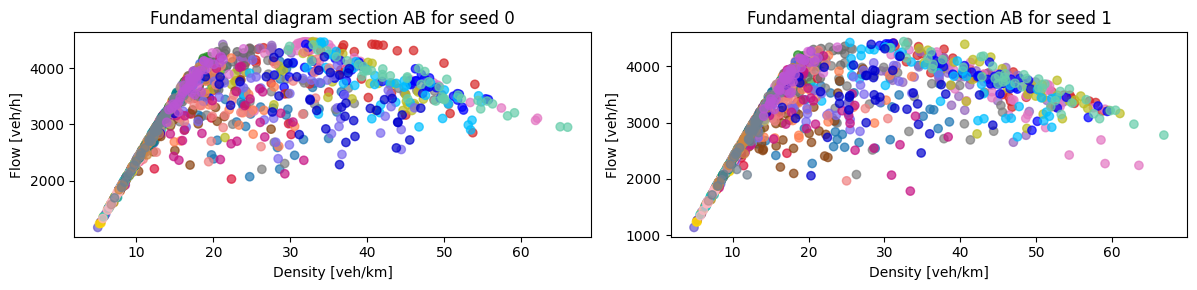

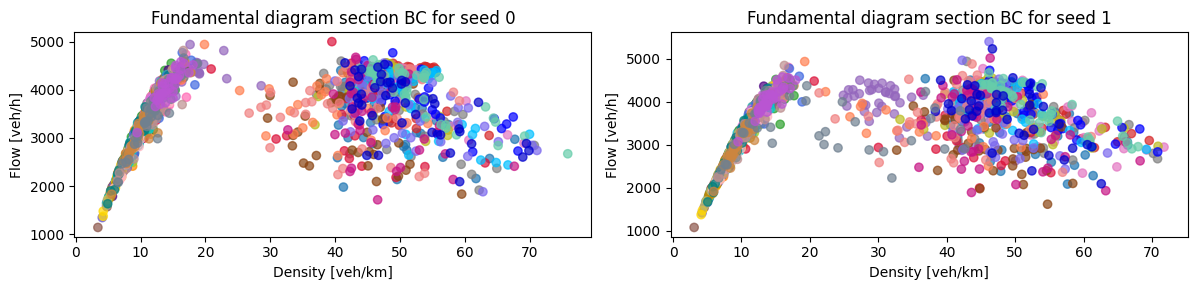

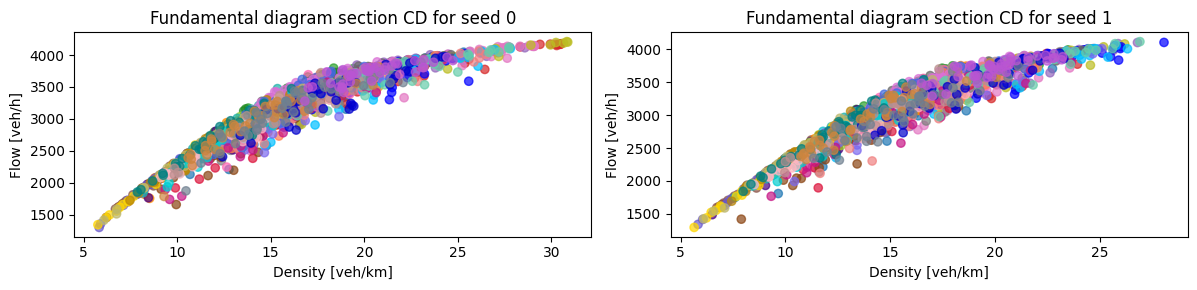

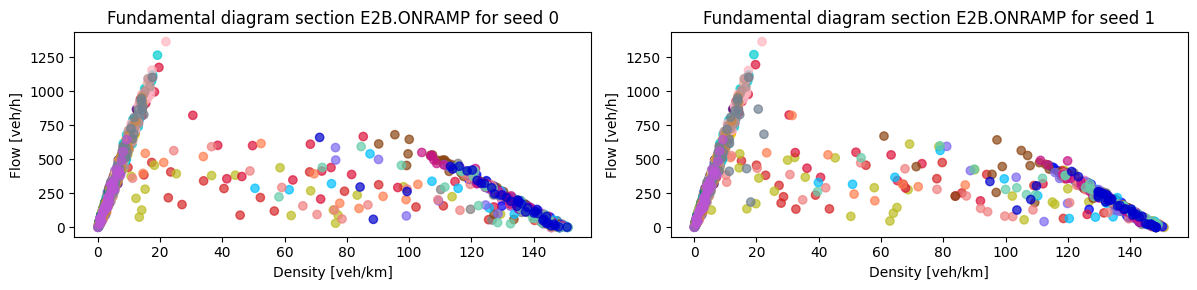

In [8]:
# combine road areas
df_fd_combined = pd.DataFrame()
# get run info
df_fd_combined['time'] = df_fd['time']
df_fd_combined['main_demand'] = df_fd['main_demand']
df_fd_combined['ramp_demand'] = df_fd['ramp_demand']
df_fd_combined['seed'] = df_fd['seed']
df_fd_combined['run'] = df_fd['run']
# create AB section (main lanes pre-merging)
df_fd_combined['AB_flow'] = df_fd['AB.LEFT_flow'] + df_fd['AB.RIGHT_flow']
df_fd_combined['AB_density'] = (df_fd['AB.LEFT_density'] + df_fd['AB.RIGHT_density']) / 2
df_fd_combined['AB_speed'] = (df_fd['AB.LEFT_speed'] + df_fd['AB.RIGHT_speed']) / 2
# create BC section (main lanes + merging lane)
df_fd_combined['BC_flow'] = df_fd['BC.LEFT_flow'] + df_fd['BC.RIGHT_flow'] + df_fd['BC.ONRAMP_flow']
df_fd_combined['BC_density'] = (df_fd['BC.LEFT_density'] + df_fd['BC.RIGHT_density'] + df_fd['BC.ONRAMP_density']) / 3
df_fd_combined['BC_speed'] = (df_fd['BC.LEFT_speed'] + df_fd['BC.RIGHT_speed'] + df_fd['BC.ONRAMP_speed']) / 3
# create CD section (main lanes post-merging)
df_fd_combined['CD_flow'] = df_fd['CD.LEFT_flow'] + df_fd['CD.RIGHT_flow']
df_fd_combined['CD_density'] = (df_fd['CD.LEFT_density'] + df_fd['CD.RIGHT_density']) / 2
df_fd_combined['CD_speed'] = (df_fd['CD.LEFT_speed'] + df_fd['CD.RIGHT_speed']) / 2
# also include onramp lane
df_fd_combined['E2B.ONRAMP_flow'] = df_fd['E2B.ONRAMP_flow']
df_fd_combined['E2B.ONRAMP_density'] = df_fd['E2B.ONRAMP_density']
df_fd_combined['E2B.ONRAMP_speed'] = df_fd['E2B.ONRAMP_speed']
    
df_new_fd = convert_fd_data(df_fd_combined)
show_fd_scatter_plot_seeds(df_new_fd, 'AB_density', 'AB_flow')
show_fd_scatter_plot_seeds(df_new_fd, 'BC_density', 'BC_flow')
show_fd_scatter_plot_seeds(df_new_fd, 'CD_density', 'CD_flow')
show_fd_scatter_plot_seeds(df_new_fd, 'E2B.ONRAMP_density', 'E2B.ONRAMP_flow')

We see ...

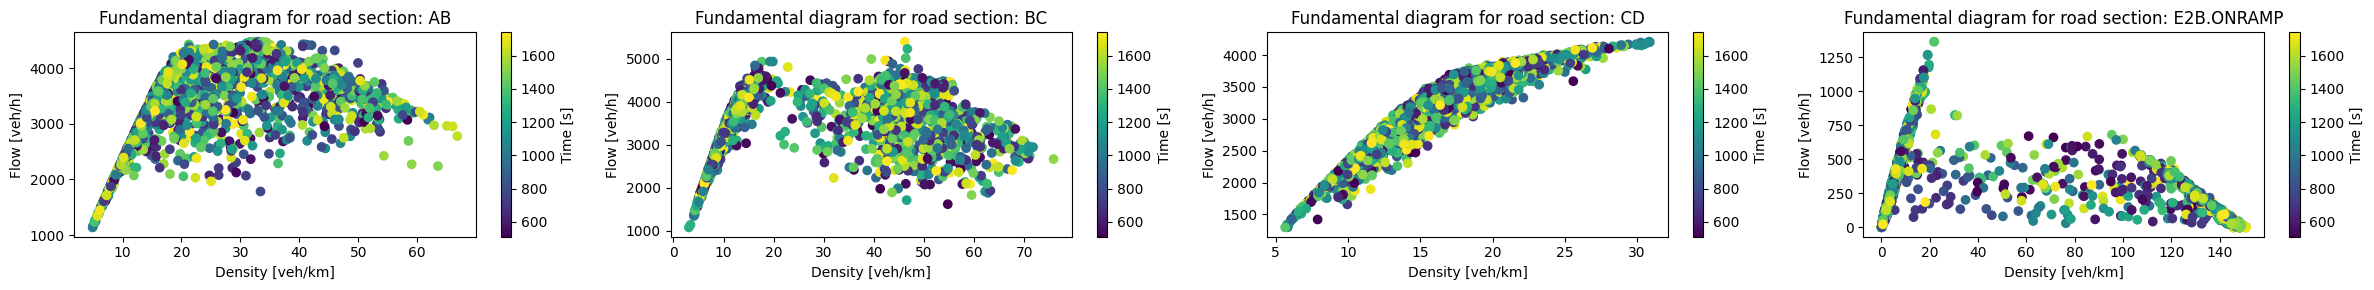

In [9]:
show_fd_scatter_plot_sections(df_new_fd, ['AB', 'BC', 'CD', 'E2B.ONRAMP'])

We see...

Time aspect: varying conditions through simulation time

Lane aspect: Curve for AB, ONRAMP has big capacity drop and influences BC. CD is limited by the bottleneck in BC and while its flow does flatten out, the lanes can facilitate the traffic coming through the bottleneck because no congestion is seen.

In [10]:
# set box limits to filter FD values
def remove_demand_non_compliant_runs(df, min_main_value, max_main_value, min_ramp_value, max_ramp_value):
    # identify runs with any data points outside the box
    non_compliant_runs = df[
        (df['main_demand'] <= min_main_value) | 
        (df['main_demand'] >= max_main_value) | 
        (df['ramp_demand'] <= min_ramp_value) | 
        (df['ramp_demand'] >= max_ramp_value)
        ][['seed', 'run']].drop_duplicates()

    # filter out these non-compliant runs from the main DataFrame
    df_filtered = df.merge(non_compliant_runs, on=['seed', 'run'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    # return new DataFrame
    return df_filtered

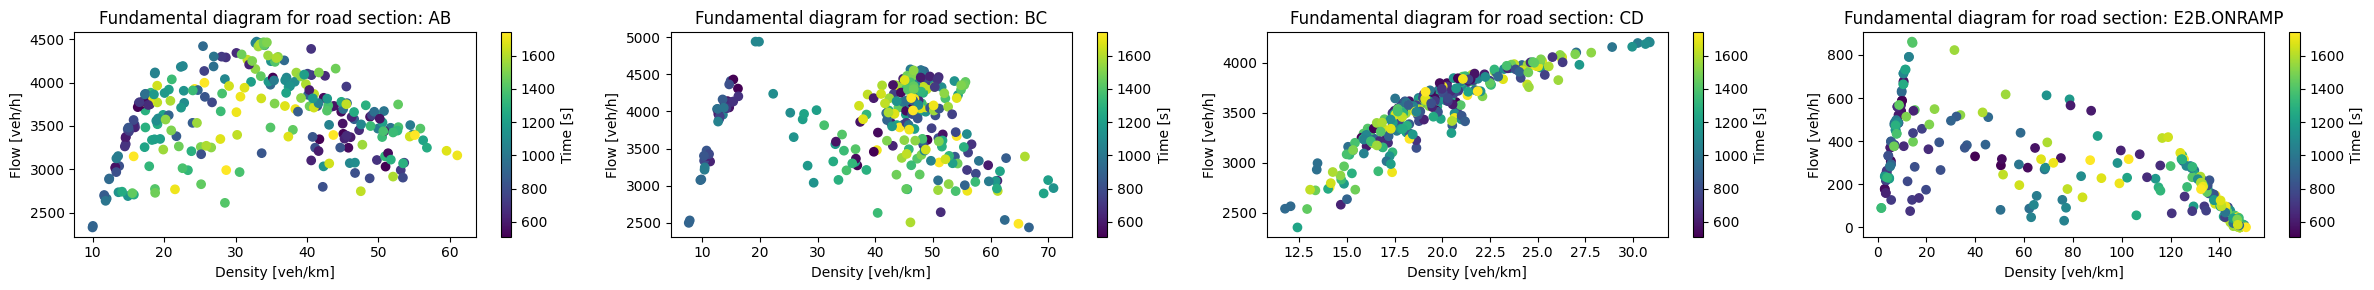

In [11]:
# show original data filtered for demand values
min_main = 3200
max_main = 4000
min_ramp = 400
max_ramp = 600
df_demand_box = remove_demand_non_compliant_runs(df_new_fd, min_main, max_main, min_ramp, max_ramp)

# show refined scatter plot
show_fd_scatter_plot_sections(df_demand_box, ['AB', 'BC', 'CD', 'E2B.ONRAMP'])

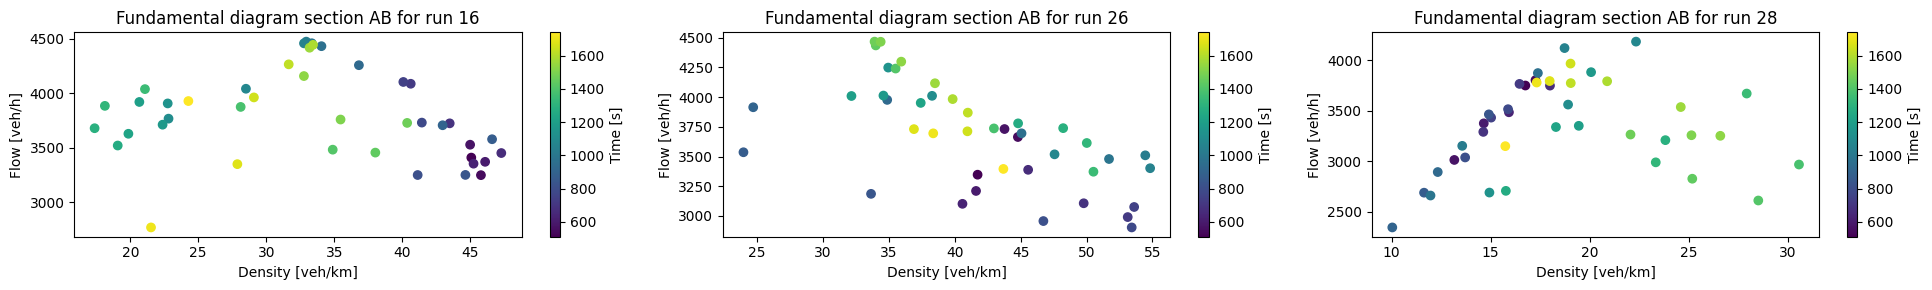

In [14]:
show_fd_scatter_plot_runs(df_demand_box, 'AB_density', 'AB_flow')

How much freeflow and congestion do we see?

### Conclusions
Demand...